# ATR_Reversal_Signal by ChatGPT - Strategy - Backtesting 

### Import Library

In [14]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import numpy as np
import pandas_ta as ta
from backtesting.backtesting import Backtest, Strategy

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 120

### Load Price Data

In [2]:
import os
from pathlib import Path
notebook_path = os.getcwd()
algo_dir = Path(notebook_path).parent.parent
csv_file = str(algo_dir) + '/vn-stock-data/VN30ps/VN30F1M_5minutes.csv'
is_file = os.path.isfile(csv_file)
if is_file:
    dataset = pd.read_csv(csv_file, index_col='Date', parse_dates=True)
else:
    print('remote')
    dataset = pd.read_csv("https://raw.githubusercontent.com/zuongthaotn/vn-stock-data/main/VN30ps/VN30F1M_5minutes.csv", index_col='Date', parse_dates=True)

In [3]:
data = dataset.copy()

In [4]:
# data = data[(data.index > '2020-11-01 00:00:00') & (data.index < '2024-10-01 00:00:00')]
data = data[data.index > '2024-11-01 00:00:00']

In [5]:
data

,Open,High,Low,Close,Volume
Date,,,,,
2024-11-01 09:00:00,1340.4,1340.4,1337.5,1337.8,10641
2024-11-01 09:05:00,1337.8,1338.6,1337.2,1338.1,5701
2024-11-01 09:10:00,1338.0,1338.0,1336.9,1337.5,3227
2024-11-01 09:15:00,1337.5,1338.0,1337.1,1337.7,2665
2024-11-01 09:20:00,1337.7,1338.8,1337.4,1338.6,3173
...,...,...,...,...,...
2025-02-25 14:15:00,1358.4,1360.8,1358.2,1360.5,6708
2025-02-25 14:20:00,1360.3,1362.1,1359.4,1361.0,7025
2025-02-25 14:25:00,1361.0,1362.2,1360.8,1361.7,4896


In [6]:
def prepare_data(df):
    df['TR'] = df[['High', 'Low', 'Close']].max(axis=1) - df[['High', 'Low', 'Close']].min(axis=1)
    df['ATR'] = df['TR'].rolling(14).mean()
    
    df['Price_Exceeds_ATR'] = (df['High'] - df['Low']) > df['ATR'] * 1.3
    df['Reversal_Candle'] = df['Close'].shift(1) > df['Close']
    
    df['ATR_Reversal_Signal'] = df['Price_Exceeds_ATR'] & df['Reversal_Candle']
    return df

In [7]:
prepared_data = prepare_data(data)
prepared_data.dropna(inplace=True)

In [8]:
class MainStrategy(Strategy):
    reward_on_risk = 3
    def init(self):
        self._broker._cash = 1500
        super().init()

    def next(self):
        super().next()
        _time = self.data.index
        current_time = _time[-1]
        if current_time.hour == 14 and current_time.minute >= 25:
            if self.position.is_long or self.position.is_short:
                self.position.close()
            return

        if self.position:
            return 
        signal = self.data.ATR_Reversal_Signal[-1]
        close_price = self.data.Close[-1]
        open_price = self.data.Open[-1]
        if signal == True:
            sell_price = close_price
            sl = sell_price + 3
            tp = sell_price - self.reward_on_risk * 3
            self.sell(size=1, sl=sl, tp=tp)

In [9]:
bt = Backtest(prepared_data, MainStrategy, commission=.0003, exclusive_orders=True)
stats = bt.run()

In [10]:
stats

Start                     2024-11-01 10:05:00
End                       2025-02-25 14:45:00
Duration                    116 days 04:40:00
Exposure Time [%]                   62.816901
Equity Final [$]                   1461.34621
Equity Peak [$]                    1526.33846
Return [%]                          -2.576919
Buy & Hold Return [%]                1.629297
Return (Ann.) [%]                   -8.886644
Volatility (Ann.) [%]                 6.01344
Sharpe Ratio                        -1.477797
Sortino Ratio                       -1.802947
Calmar Ratio                        -1.989086
Max. Drawdown [%]                   -4.467702
Avg. Drawdown [%]                   -0.472526
Max. Drawdown Duration      105 days 01:05:00
Avg. Drawdown Duration        7 days 06:04:00
# Trades                                  156
Win Rate [%]                        34.615385
Best Trade [%]                       0.674589
Worst Trade [%]                     -0.277367
Avg. Trade [%]                    

In [11]:
stats['_trades']

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Tag,Duration
0,-1,14,24,1334.89941,1338.0,-3.10059,-0.002323,2024-11-01 11:15:00,2024-11-01 13:30:00,None,0 days 02:15:00
1,-1,25,36,1335.39926,1328.8,6.59926,0.004942,2024-11-01 13:35:00,2024-11-01 14:30:00,None,0 days 00:55:00
2,-1,50,87,1324.60250,1320.0,4.60250,0.003475,2024-11-04 10:00:00,2024-11-04 14:30:00,None,0 days 04:30:00
3,-1,127,138,1322.10325,1320.2,1.90325,0.001440,2024-11-05 13:35:00,2024-11-05 14:30:00,None,0 days 00:55:00
4,-1,144,171,1326.20202,1329.6,-3.39798,-0.002562,2024-11-06 09:20:00,2024-11-06 13:00:00,None,0 days 03:40:00
...,...,...,...,...,...,...,...,...,...,...,...
151,-1,3792,3801,1353.59380,1351.4,2.19380,0.001621,2025-02-21 13:45:00,2025-02-21 14:30:00,None,0 days 00:45:00
152,-1,3804,3805,1351.69437,1355.1,-3.40563,-0.002520,2025-02-24 09:05:00,2025-02-24 09:10:00,None,0 days 00:05:00
153,-1,3810,3817,1354.09365,1357.4,-3.30635,-0.002442,2025-02-24 09:35:00,2025-02-24 10:10:00,None,0 days 00:35:00
154,-1,3818,3848,1356.19302,1359.5,-3.30698,-0.002438,2025-02-24 10:15:00,2025-02-24 14:10:00,None,0 days 03:55:00


In [12]:
# bt.plot()

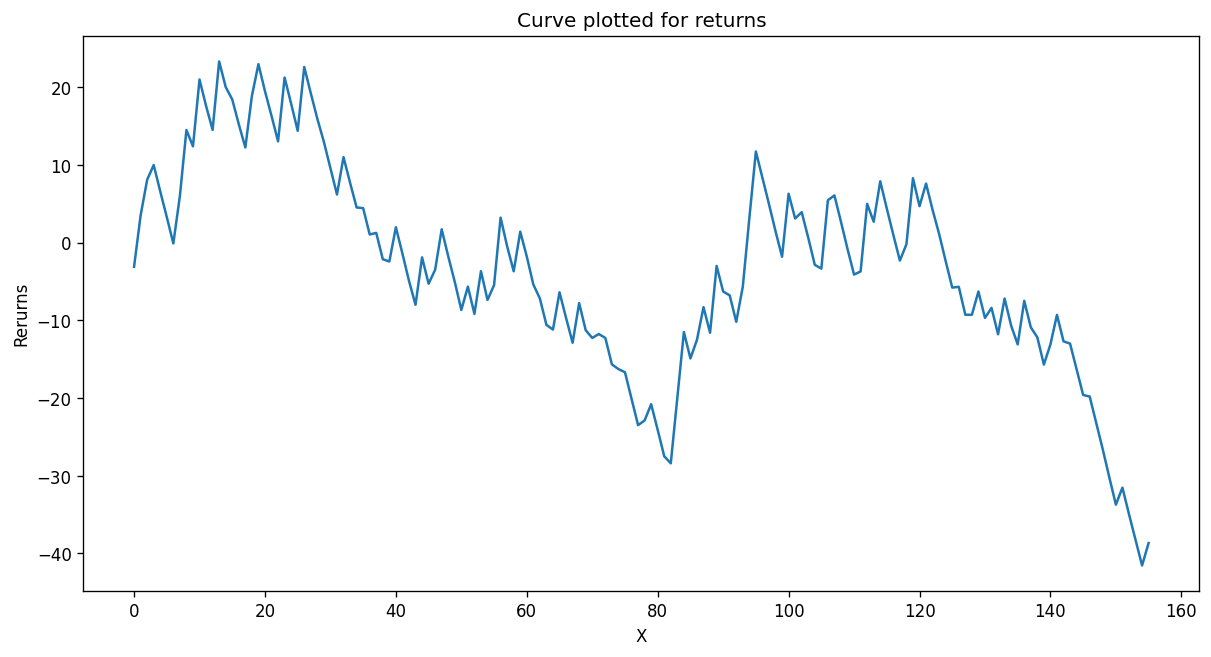

In [13]:
copy_trades = stats['_trades'].copy()
copy_trades['cum_sum'] = copy_trades['PnL'].cumsum()
X = np.array(range(0, len(copy_trades['cum_sum'])))
Y = copy_trades['cum_sum']
# Plotting the Graph
plt.plot(X, Y)
plt.title("Curve plotted for returns")
plt.xlabel("X")
plt.ylabel("Rerurns")
plt.show()